In [2]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import defaultdict

corpus = [
    "king is a strong man",
    "queen is a wise woman",
    "boy is a young man",
    "girl is a young woman",
    "prince is a young king",
    "princess is a young queen",
    "man is strong",
    "woman is pretty",
    "prince is boy will be king",
    "princess is girl will be queen"
]

def tokenize_corpus(corpus):
    return [sentence.lower().split() for sentence in corpus]

tokenized_corpus = tokenize_corpus(corpus)


In [3]:

def build_vocab(tokenized_corpus):
    word_freq = defaultdict(int)
    for sentence in tokenized_corpus:
        for word in sentence:
            word_freq[word] += 1
    word_to_idx = {word: idx for idx, word in enumerate(word_freq)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    return word_to_idx, idx_to_word

word_to_idx, idx_to_word = build_vocab(tokenized_corpus)
vocab_size = len(word_to_idx)
print("Vocabulary:", word_to_idx)


Vocabulary: {'king': 0, 'is': 1, 'a': 2, 'strong': 3, 'man': 4, 'queen': 5, 'wise': 6, 'woman': 7, 'boy': 8, 'young': 9, 'girl': 10, 'prince': 11, 'princess': 12, 'pretty': 13, 'will': 14, 'be': 15}


In [4]:

def generate_cbow_data(tokenized_corpus, window_size=2):
    data = []
    for sentence in tokenized_corpus:
        for idx, word in enumerate(sentence):
            context = []
            for neighbor in range(-window_size, window_size + 1):
                if neighbor == 0 or idx + neighbor < 0 or idx + neighbor >= len(sentence):
                    continue
                context.append(sentence[idx + neighbor])
            data.append((context, word))
    return data

training_data = generate_cbow_data(tokenized_corpus)
print("Sample training pair:", training_data[0])


Sample training pair: (['is', 'a'], 'king')


In [5]:

class CBOW:
    def __init__(self, vocab_size, embedding_dim):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.W1 = np.random.rand(vocab_size, embedding_dim)
        self.W2 = np.random.rand(embedding_dim, vocab_size)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    def forward(self, context_vectors):
        h = np.mean(context_vectors, axis=0)
        u = np.dot(h, self.W2)
        y_pred = self.softmax(u)
        return y_pred, h

    def train(self, training_data, word_to_idx, epochs=100, learning_rate=0.05):
        for epoch in range(epochs):
            loss = 0
            for context, target in training_data:
                context_vectors = np.array([self.W1[word_to_idx[w]] for w in context])
                y_pred, h = self.forward(context_vectors)
                target_vec = np.zeros(self.vocab_size)
                target_vec[word_to_idx[target]] = 1
                e = y_pred - target_vec

                dW2 = np.outer(h, e)
                dW1 = np.dot(self.W2, e) / len(context)

                for word in context:
                    self.W1[word_to_idx[word]] -= learning_rate * dW1
                self.W2 -= learning_rate * dW2

                loss += -np.log(y_pred[word_to_idx[target]] + 1e-7)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def get_embeddings(self):
        return self.W1


In [6]:

model = CBOW(vocab_size, embedding_dim=10)
model.train(training_data, word_to_idx, epochs=100, learning_rate=0.05)
embeddings = model.get_embeddings()


Epoch 0, Loss: 135.2062
Epoch 10, Loss: 108.7498
Epoch 20, Loss: 87.1622
Epoch 30, Loss: 68.5949
Epoch 40, Loss: 54.8784
Epoch 50, Loss: 45.3982
Epoch 60, Loss: 39.2917
Epoch 70, Loss: 35.4383
Epoch 80, Loss: 32.9345
Epoch 90, Loss: 31.2300


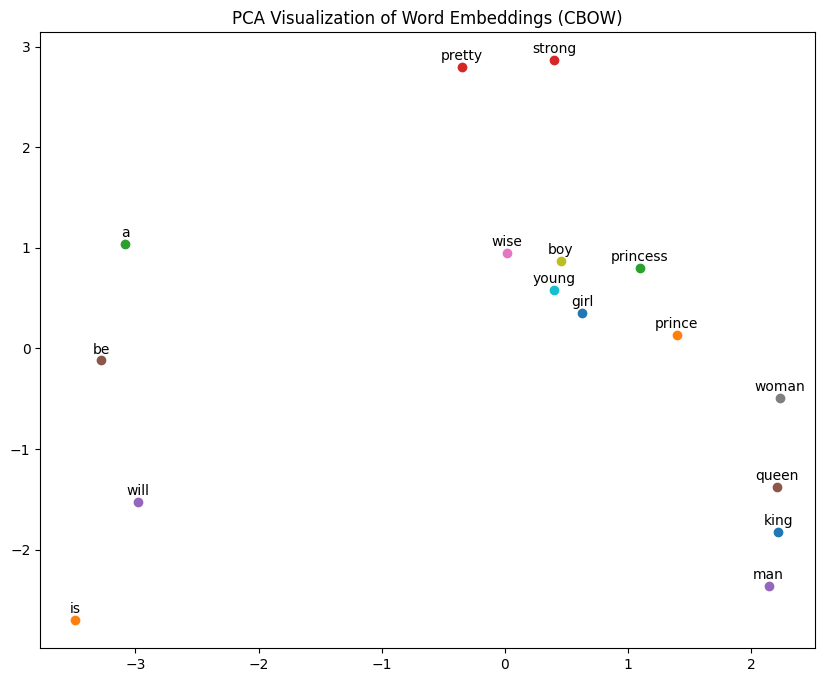

In [7]:

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
for i, word in enumerate(word_to_idx):
    x, y = reduced[i]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), textcoords="offset points", xytext=(0, 5), ha='center')
plt.title("PCA Visualization of Word Embeddings (CBOW)")
plt.show()


In [8]:

def most_similar(word, top_n=5):
    idx = word_to_idx[word]
    vec = embeddings[idx]
    sims = embeddings @ vec
    sims[idx] = -np.inf  # ignore itself
    top_indices = np.argsort(sims)[-top_n:][::-1]
    print(f"Words similar to '{word}':")
    for i in top_indices:
        print(f"{idx_to_word[i]} (score: {sims[i]:.3f})")

most_similar("king")
most_similar("princess")


Words similar to 'king':
queen (score: 17.200)
man (score: 15.593)
woman (score: 9.309)
young (score: 8.772)
prince (score: 7.747)
Words similar to 'princess':
prince (score: 9.440)
girl (score: 8.208)
woman (score: 7.462)
boy (score: 7.269)
pretty (score: 7.154)
